In [62]:
import requests
import json
import urllib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import re
import numpy as np
from PIL import Image
import io
import torchvision.transforms as transforms
import torch
import random
import os
import shutil
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import correlate
import cv2

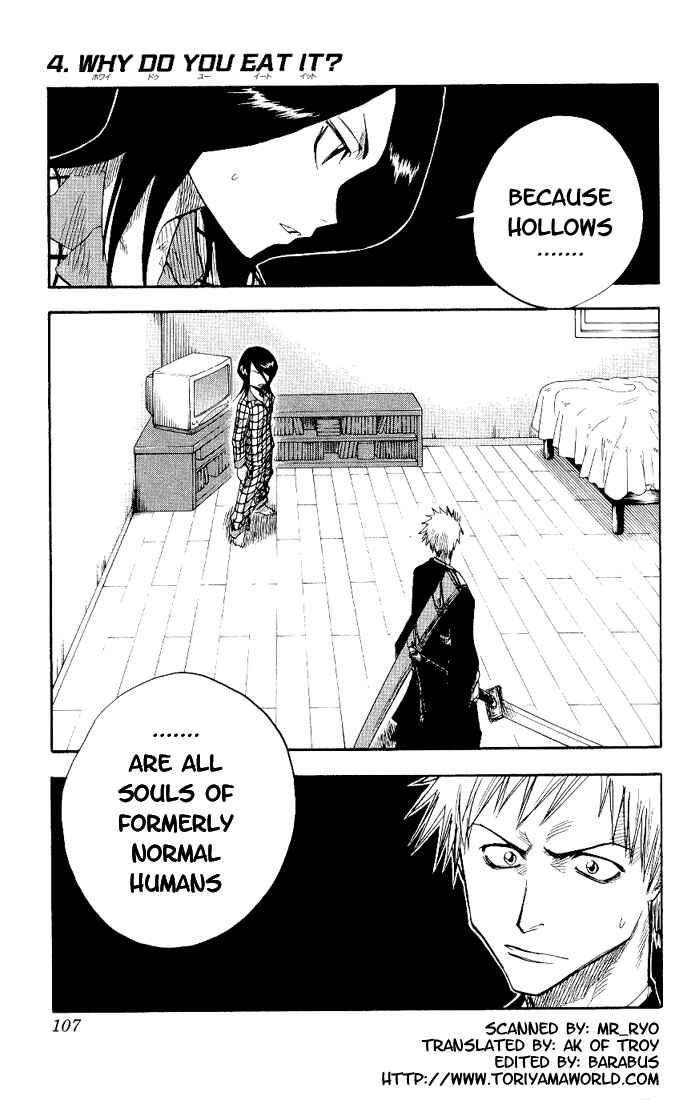

In [2]:
title = 'bleach'
chapter = '4'

bw_path = '/'.join(['bw', title, chapter, '1.jpg'])
bw_pic = Image.open(bw_path)

color_path = '/'.join(['color', title, chapter, '0.jpg'])
color_pic = Image.open(color_path)

bw_width, bw_height = bw_pic.size
color_width, color_height = color_pic.size

min_width = min(bw_width, color_width)
min_height = min(bw_height, color_height)
min_size = (min_width, min_height)

bw_pic_resize = bw_pic.resize(min_size)
color_pic_resize = color_pic.resize(min_size)

bw_pic_resize

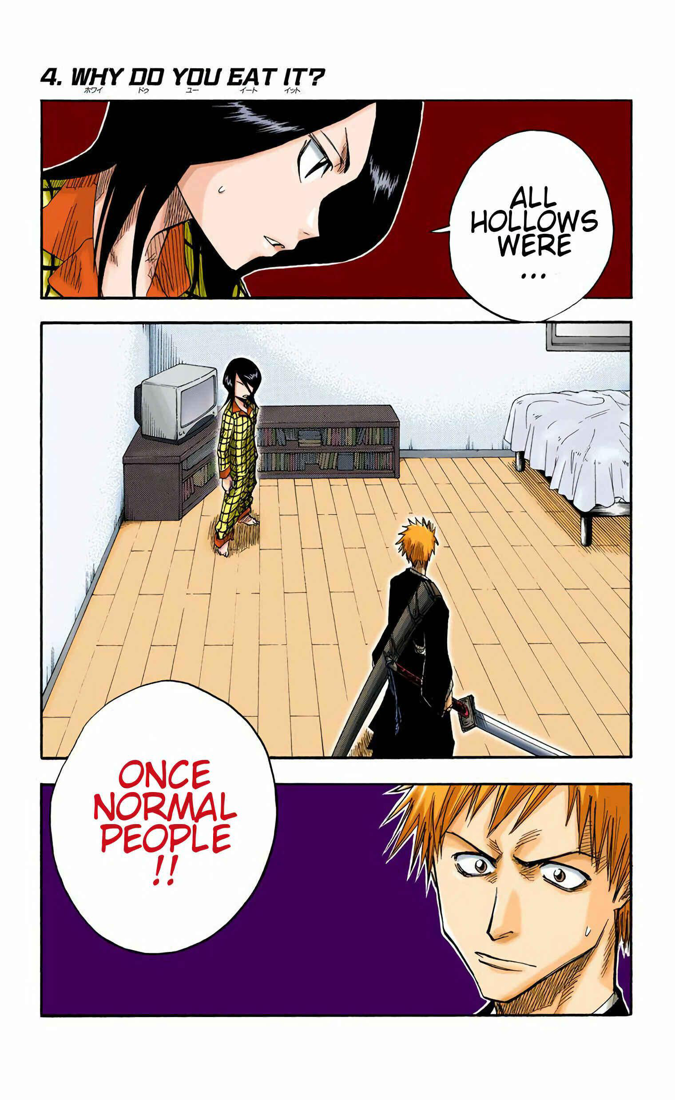

In [3]:
color_pic_resize

In [4]:
def find_mapping(list1, list2):
    good_elements_indices = {}
    mapping = {}

    for index, elem in enumerate(list1):
        good_elements_indices[elem] = index

    for index, elem in enumerate(list2):
        list1_index = good_elements_indices.get(elem)
        if list1_index is not None and is_match(list1[list1_index], elem):
            mapping[list1_index] = index
    
    return mapping

def is_match(e1, e2):
    return e1 == e2 

list1 = ['T1', 'T2', 'G1', 'G2', 'G3', 'G4', 'T3']
list2 = ['T4', 'G1', 'T5', 'T6', 'G2', 'G3', 'G4']

result_mapping = find_mapping(list1, list2)
print(result_mapping)

{2: 1, 3: 4, 4: 5, 5: 6}


In [17]:
def calculate_image_similarity(bw_pic, bw_color_pic):
    bw_array = np.array(bw_pic)
    bw_color_array = np.array(bw_color_pic)

    similarity_index, n = ssim(bw_array, bw_color_array, full=True)

    return similarity_index

color_bw_pic_resize = color_pic_resize.convert("L")
calculate_image_similarity(bw_pic_resize, color_bw_pic_resize)

0.3742508688524279

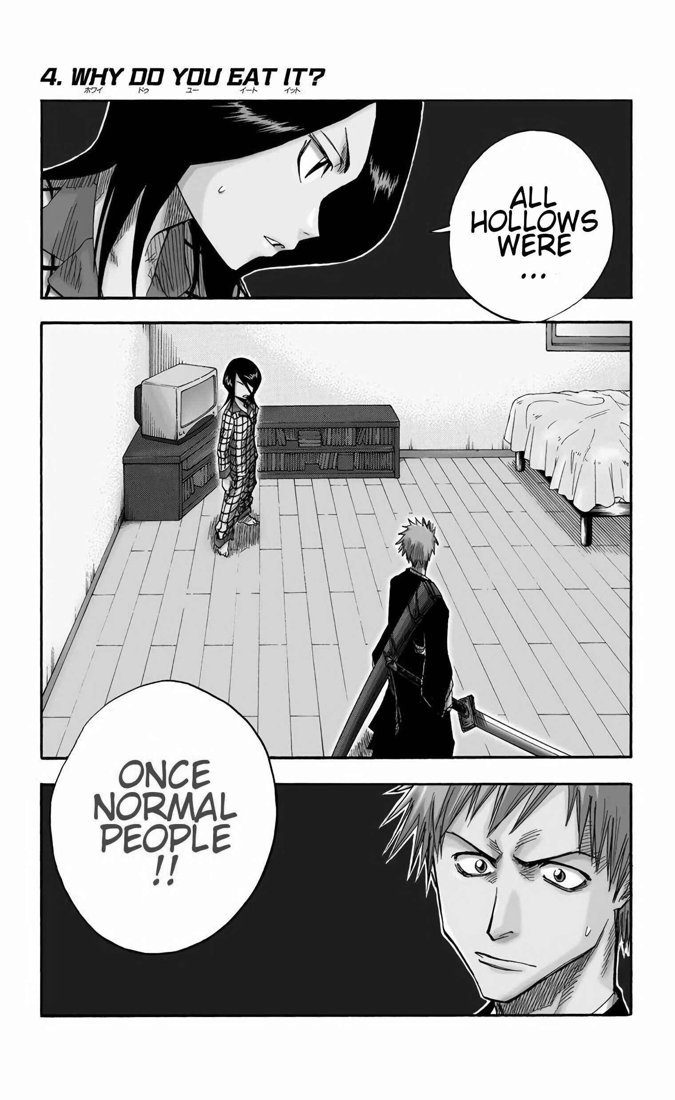

In [6]:
color_bw_pic_resize

In [7]:
color_bw_arr = np.array(color_bw_pic_resize)
bw_arr = np.array(bw_pic_resize)

In [7]:
color_bw_arr

array([[253, 253, 253, ..., 253, 253, 253],
       [253, 253, 253, ..., 253, 253, 253],
       [253, 253, 253, ..., 253, 253, 253],
       ...,
       [253, 253, 253, ..., 253, 253, 253],
       [253, 253, 253, ..., 253, 253, 253],
       [253, 253, 253, ..., 253, 253, 253]], dtype=uint8)

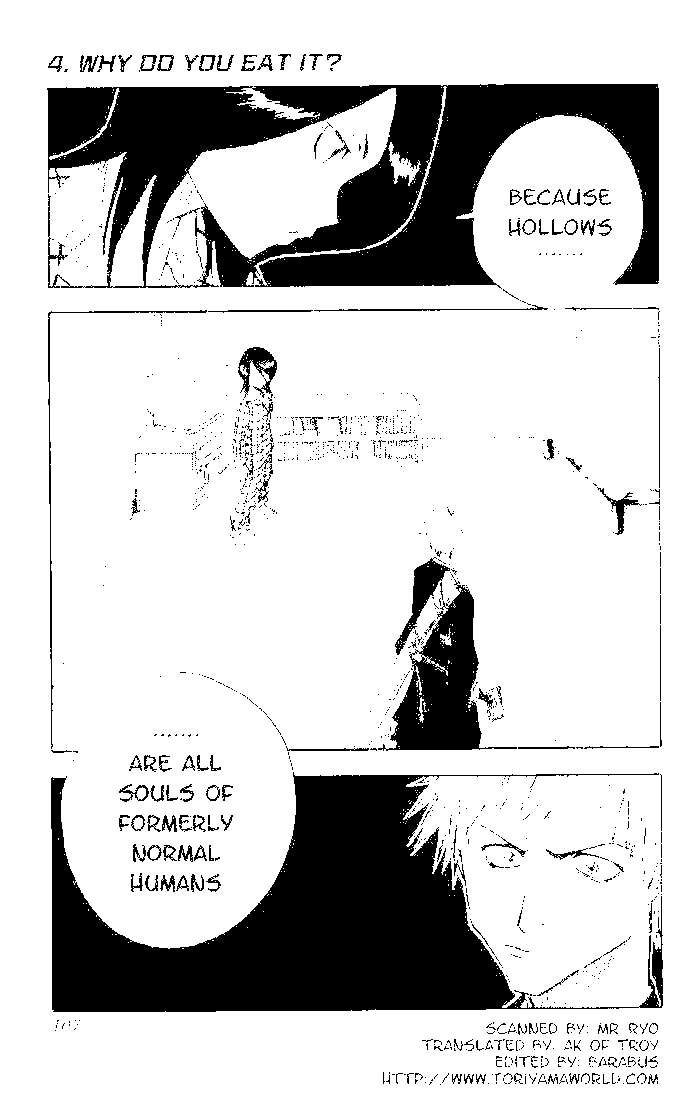

In [10]:
black_mask1 = (bw_arr <= 20)
new_array1 = np.where(black_mask1, 0, 255)

Image.fromarray(new_array1.astype(np.uint8), mode='L')

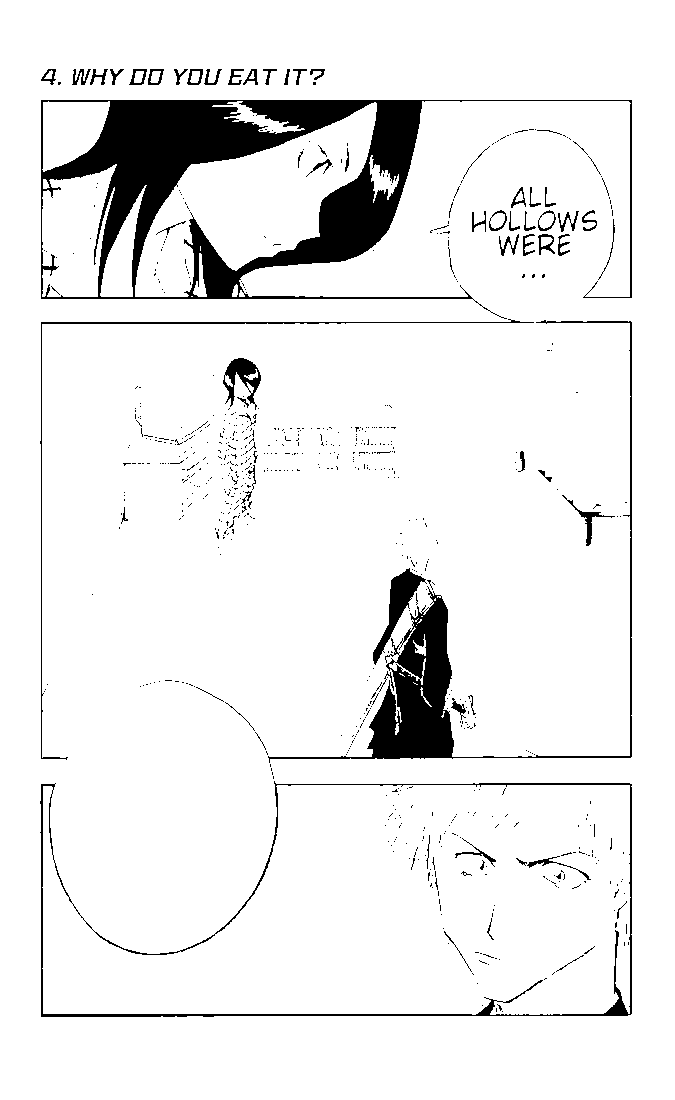

In [11]:
black_mask2 = (color_bw_arr <= 20)
new_array2 = np.where(black_mask2, 0, 255)

Image.fromarray(new_array2.astype(np.uint8), mode='L')

In [12]:
ssim(new_array1, new_array2, full=True)

(0.9999999999942836,
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

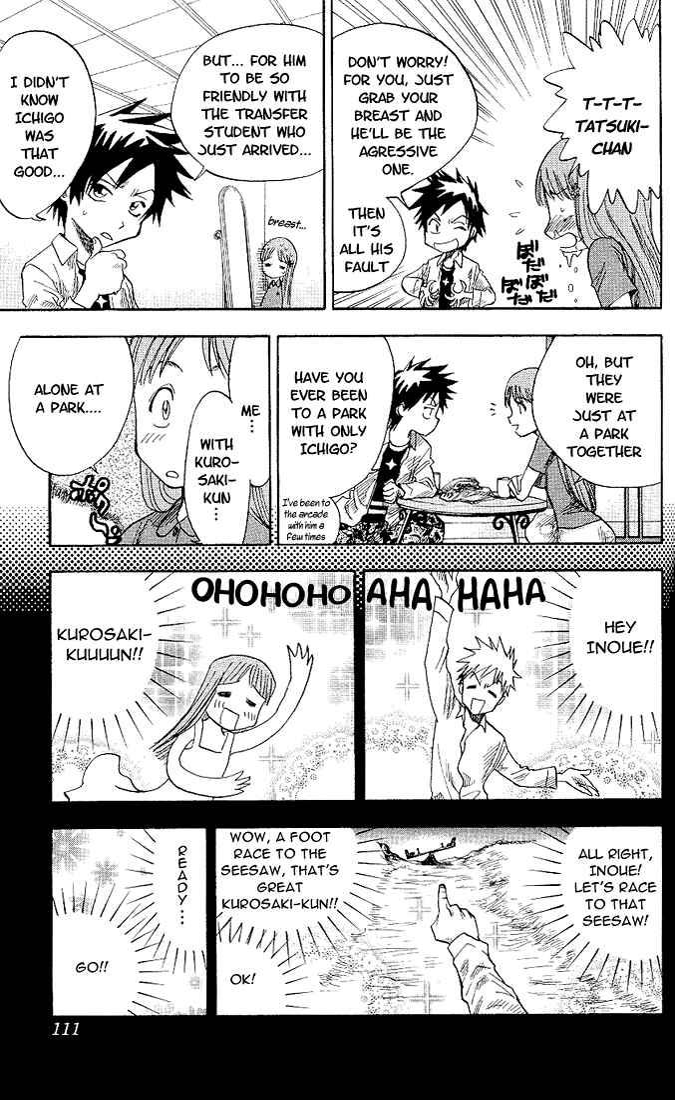

In [13]:
test_path = '/'.join(['bw', title, chapter, '5.jpg'])
test_pic = Image.open(test_path)
test_pic_resize = test_pic.resize(min_size)
test_pic_resize

In [27]:
test_arr = np.array(test_pic_resize)
black_mask3 = (test_arr <= 20)
new_array3 = np.where(black_mask3, 0, 255)
ssim(new_array1, new_array2)

0.9999999999942836

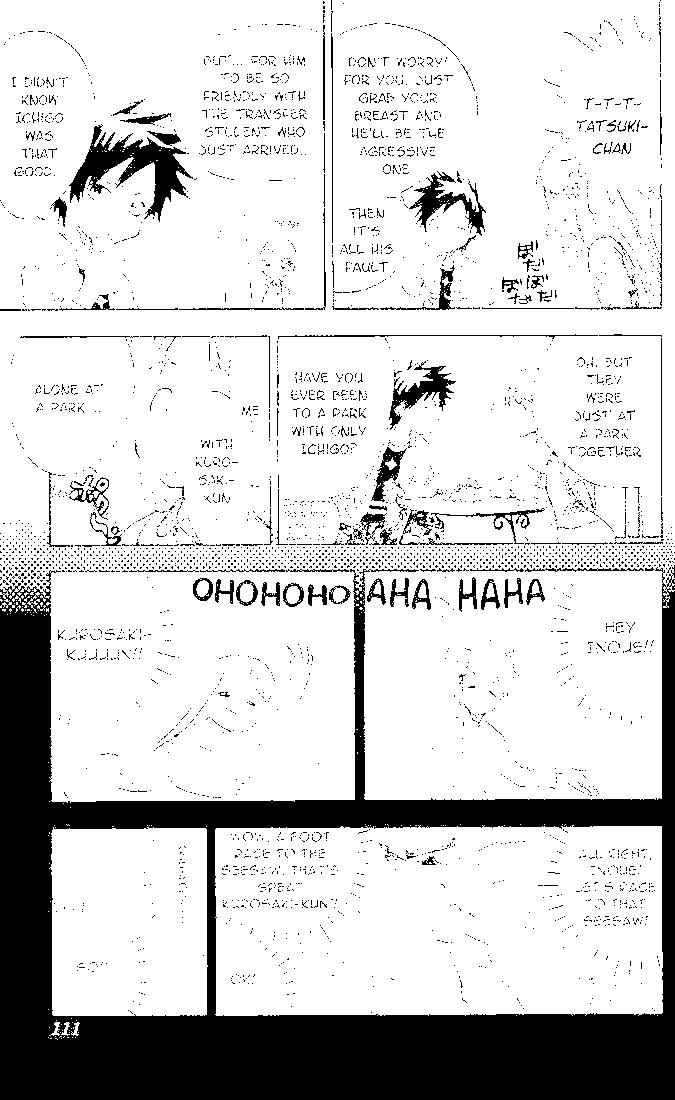

In [24]:
Image.fromarray(new_array3.astype(np.uint8), mode='L')

In [28]:
def percentage_equal(arr1, arr2):
    # Ensure both arrays have the same shape
    if arr1.shape != arr2.shape:
        raise ValueError("Arrays must have the same shape.")

    # Count the number of equal elements
    equal_elements = np.sum(arr1 == arr2)

    # Calculate the percentage of equal elements
    total_elements = arr1.size
    percentage = (equal_elements / total_elements) * 100

    return percentage

In [32]:
percentage_equal(new_array1, new_array2)

79.6189898989899

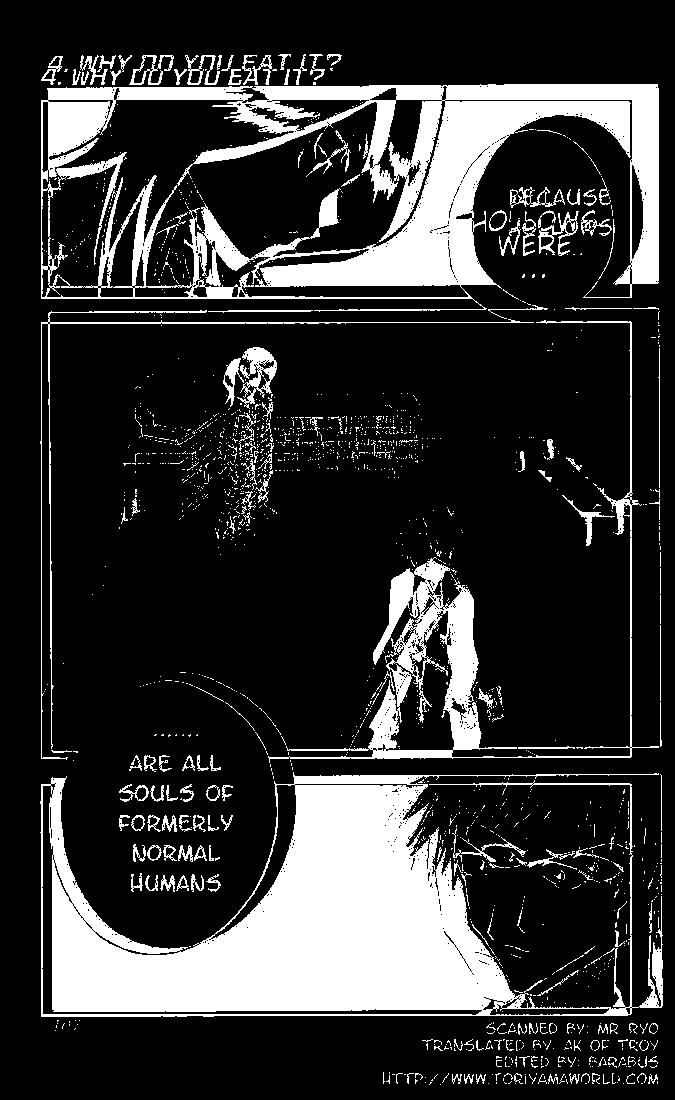

In [54]:
diff_array = np.where(new_array2 == new_array1, 0, 255)
Image.fromarray(diff_array.astype(np.uint8), mode='L')

In [51]:
def g(arr):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i][j] < 30:
                return (i,j)
g(color_bw_arr), g(bw_arr), 

((68, 50), (54, 247))

In [45]:
color_bw_arr.shape

(1100, 675)

C:\Users\dbala\AppData\Local\Temp\ipykernel_11256\153052003.py:1: RuntimeWarning: divide by zero encountered in true_divide
  diff_array2 = np.where(color_bw_arr/test_arr > 0.8 , 0, 255)
C:\Users\dbala\AppData\Local\Temp\ipykernel_11256\153052003.py:1: RuntimeWarning: invalid value encountered in true_divide
  diff_array2 = np.where(color_bw_arr/test_arr > 0.8 , 0, 255)


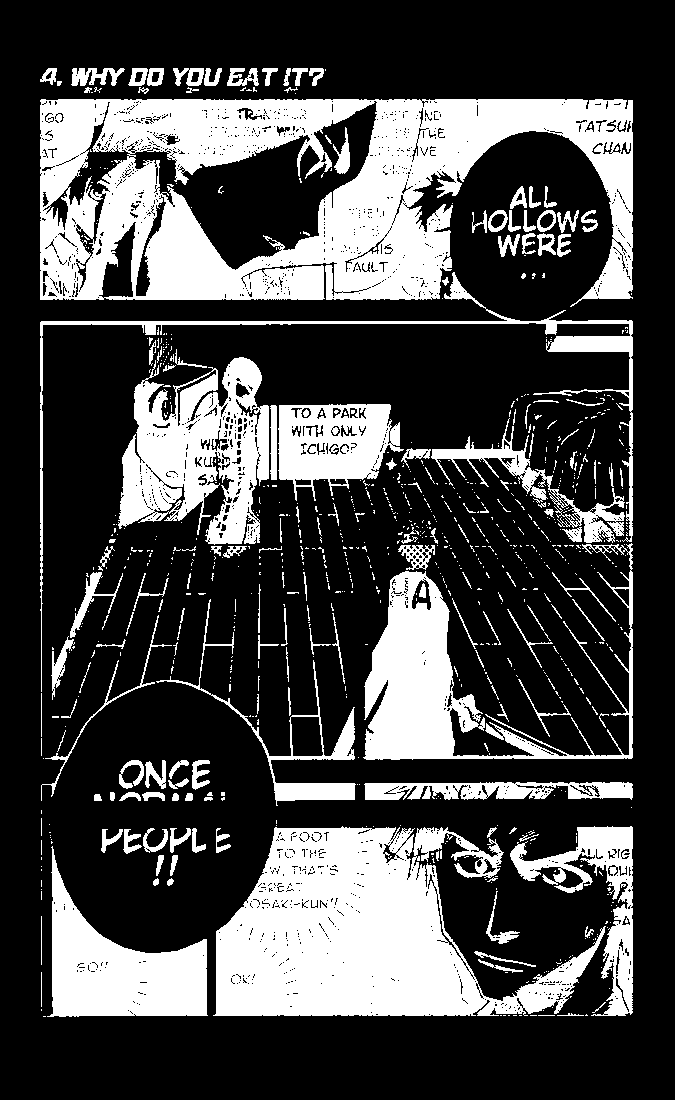

In [60]:
diff_array2 = np.where(color_bw_arr/test_arr > 0.8 , 0, 255)
Image.fromarray(diff_array2.astype(np.uint8), mode='L')

In [61]:
def within_10_percent(arr1, arr2):
    return np.abs(arr1 - arr2) <= 0.1 * np.abs(arr1)

In [68]:
def find_offset_with_keypoints(arr1, arr2):
    # Create ORB detector
    orb = cv2.ORB_create()
    
    # Find keypoints and descriptors with ORB
    keypoints1, descriptors1 = orb.detectAndCompute(arr1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(arr2, None)

    # Create BFMatcher (Brute Force Matcher)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(descriptors1, descriptors2)

    # Sort them based on distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Get corresponding points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Find the transformation matrix
    matrix, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Apply the transformation matrix to find the offset
    offset_x = matrix[0, 2]
    offset_y = matrix[1, 2]

    return offset_x, offset_y

bw_black_mask = (bw_arr <= 25)
bw_white_mask = (bw_arr >= 230)
masked_bw_arr = np.where(np.where(bw_white_mask, 0, 255), 255, 0).astype(np.uint8)

color_bw_black_mask = (color_bw_arr <= 25)
color_bw_white_mask = (color_bw_arr >= 230)
masked_color_bw_arr = np.where(np.where(color_bw_white_mask, 0, 255), 255, 0).astype(np.uint8)

offset_x, offset_y = find_offset_with_keypoints(bw_arr, color_bw_arr)

offset_x = int(offset_x)
offset_y = int(offset_y)

print("Horizontal Offset:", offset_x)
print("Vertical Offset:", offset_y)

print("")

offset_x, offset_y = find_offset_with_keypoints(masked_bw_arr, masked_color_bw_arr)

offset_x = int(offset_x)
offset_y = int(offset_y)

print("Horizontal Offset:", offset_x)
print("Vertical Offset:", offset_y)

Horizontal Offset: -4
Vertical Offset: 12

Horizontal Offset: -3
Vertical Offset: 12


In [36]:
def offset_image(image, offset_x, offset_y):
    # Create a blank image with the same mode and size
    new_image = Image.new(image.mode, image.size, 255)

    # Paste the original image onto the new image with the specified offset
    new_image.paste(image, (offset_x, offset_y))

    return new_image

color_bw_pic_resize_offset = offset_image(color_bw_pic_resize, -offset_x, -offset_y)

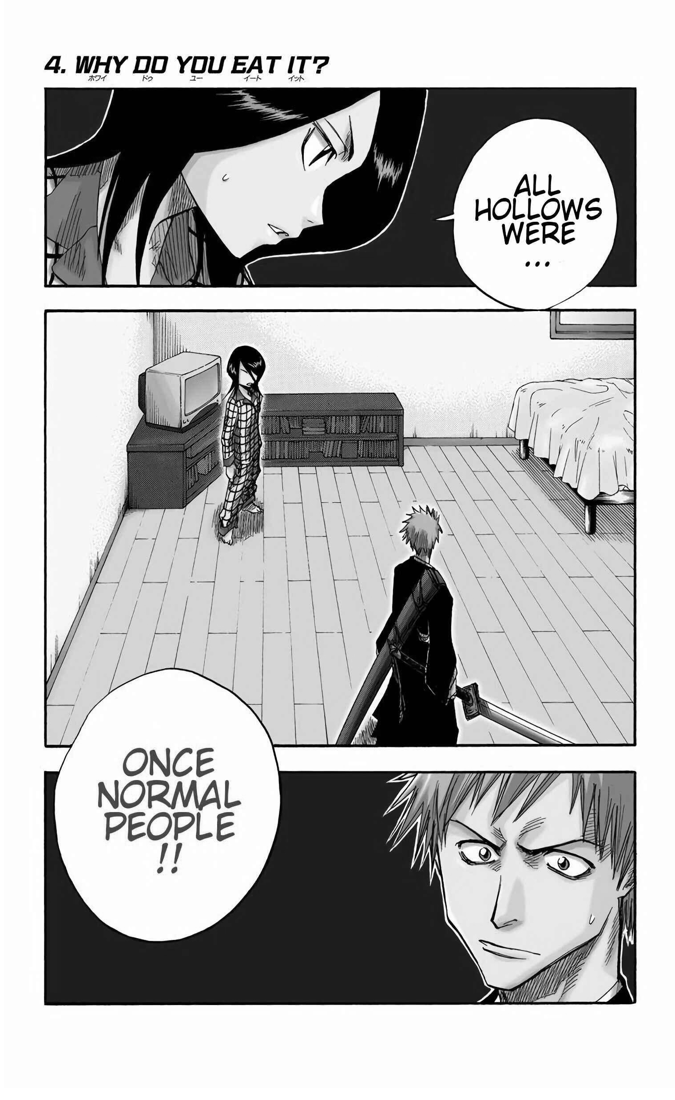

In [37]:
color_bw_pic_resize_offset

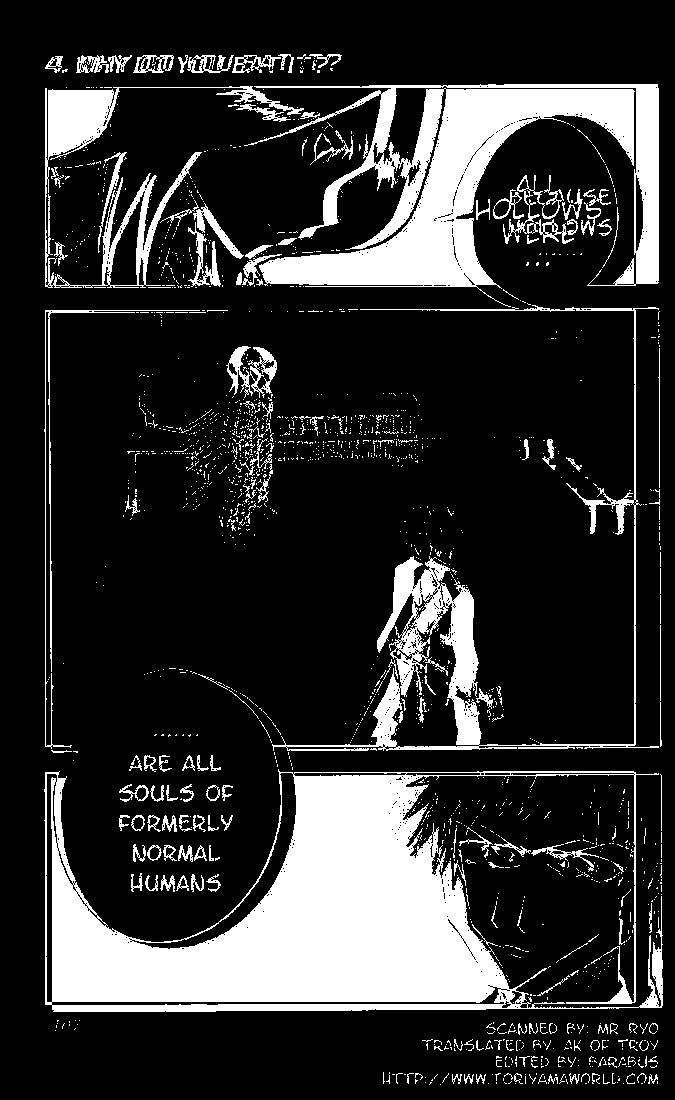

In [38]:
black_mask3 = (bw_arr <= 20)
new_array3 = np.where(black_mask3, 0, 255)

black_mask4 = (np.array(color_bw_pic_resize_offset) <= 20)
new_array4 = np.where(black_mask4, 0, 255)

diff_array2 = np.where(new_array3 == new_array4, 0, 255)
Image.fromarray(diff_array2.astype(np.uint8), mode='L')